# PUI final exam 2021

## Theoretic part

## Question 1. 
Imagine training a model that considers multiple street segments and aims to predict the traffic based on the known characteristics of the street segments. Some of the street segments from the training sample have the observed amount of traffic specified for them, others do not. How would you classify this problem from the Machine Learning perspective? C

A. Supervised learning;

B. Unsupervised learning;

C. Semi-supervised learning;

D. Reinforcement learning.

Explain your choice: This problem involves some portion of labeled examples and other unlabeled examples, so it is semi-supervised.

## Question 2. 
Regression $y\sim a_1 x_1 + a_2 x_2 +a_3 x_3$ have p-value of $0.03$ for $x_1$, $0.3$ for $x_2$ and $0.15$ for $x_3$. Does it mean that (select all that apply): CDE

A. Impact of $x_3$ is twice stronger than impact of $x_2$.

B. Regressors $x_2$ and $x_3$ are irrelevant.

C. One could reject the null-hypothesis $a_j=0$ only for $j=1$ but not for $j=2$ and $j=3$ at 95% singificance level.

D. The estimated value of $a_1$ is statistically significant.

E. 95%-confidence indervals for $a_2$ and $a_3$ should contain zero. 

## Question 3. 
Which of the following statements (select all that apply) are true about overfitting problem for linear regression: DE

A. Overfitting problem could be detected by R-squared if the in-sample R-squared
is very low.

B. Overfitting problem often happens when we do not have enough features but a big
number of observations.

C. Overfitting problem could be detected by R-squared if the out-of-sample R-
squared is very low.

D. Overfitting problem could happen when we have many noisy features but a
small number of observations.

E. Overfitting problem could be detected by R-squared if the out-of-sample R-
squared is considerably lower compared to in-sample R-squared.

Explain how do you understand the concept of overfitting in general and in the context of your answer.

## Question 4. 
You trained the regression model with 100 regressors and 1000 observations in the training and another 1000 in the test sample. You found that in-sample R2 over the training sample is 70\% and the out-of-sample R2 over the test sample only - 30\%. (select all that apply)

a) Do you think there is any problem and how would you characterize it? Can adding more regressors (if you have them) help the model?
It's probably overfitted. Adding more regressors will make it worse.

b) Which approaches you may use to solve the problem? 
 We should drop some regressors and do cross-validation.
 
c) What would you expect the in-sample R2 to increase or decrease after that? What about the out-of-sample (test) R2?
After we adjust the model, the in-sample R2 probably would decrease since we cut some regressors, but out-of-sample (test) R2 would increase. These two R2 will become more closed to each other.

In [1]:
# import packages
import numpy as np
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error, r2_score
import datetime as dt
from sklearn import linear_model
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
from scipy import stats

# suppress warning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Traffic Modeling for Real-Time Autonomous Vehicle Solutions in LGA

Transportation network models are essential to transportation operations and planning. A simple yet well-designed linear model can provide us insights into the traffic demand. We are going to model the outgoing traffic around LGA, one of the busiest transportation hubs in NYC. 
In this test, you'll be asked to:
* Find possible correlations from observations
* Incorporate time patterns using dummy variables
* Run and diagnose linear models, in-sample and out-of-sample. Perform feature selection
* Cluster the days based on their ridership patterns to see if we can detect any outliers

We will be importing the dataset `LGAVehicleByHour.csv`,`LGAFlightArrival` providing FHV and taxi ridership and arrivals at the airport aggregated on the hourly basis:
* `vehicle_count`: Number of FHV (For Hire Vehicle) and taxi departing from LGA. This is our target variable.
* `arrivals`: Number of incoming domestic flights arriving LGA, which is assumed to provide a basis for future FHV and taxi demand

In [2]:
# import and curate the dataset
TaxiRidership = pd.read_csv("LGAVehicleByHour.csv")
FlightArrival = pd.read_csv("LGAFlightArrival.csv")

In [3]:
TaxiRidership.head()

,DOLocationID,Date,vehicle_count
0,1,2018-01-01 00:00,0.0
1,2,2018-01-01 00:00,0.0
2,3,2018-01-01 00:00,0.0
3,4,2018-01-01 00:00,0.0
4,5,2018-01-01 00:00,0.0


In [4]:
FlightArrival.head()

,Date,arrivals
0,18/1/1 0:00,3
1,18/1/1 1:00,0
2,18/1/1 2:00,1
3,18/1/1 3:00,0
4,18/1/1 4:00,0


In [5]:
# convert the `date` feature into `dt.datetime` format. This is for later creating dummy variables
TaxiRidership.Date = pd.to_datetime(TaxiRidership.Date)
FlightArrival.Date = pd.to_datetime(FlightArrival.Date, format='%y/%m/%d %H:%M')

In [6]:
#get day of the week; monday - 0, sunday - 6
TaxiRidership['DOW']=pd.DatetimeIndex(TaxiRidership.Date).weekday

In [7]:
#get day from beginning of the year, hour and day of the week from datetime
TaxiRidership['Hour']=pd.DatetimeIndex(TaxiRidership.Date).hour

In [8]:
#get day from beginning of the year
TaxiRidership['day']=((TaxiRidership.Date-dt.datetime(2018,1,1))/dt.timedelta(days = 1)).astype(int)

In [9]:
TaxiRidership

,DOLocationID,Date,vehicle_count,DOW,Hour,day
0,1,2018-01-01 00:00:00,0.0,0,0,0
1,2,2018-01-01 00:00:00,0.0,0,0,0
2,3,2018-01-01 00:00:00,0.0,0,0,0
3,4,2018-01-01 00:00:00,0.0,0,0,0
4,5,2018-01-01 00:00:00,0.0,0,0,0
...,...,...,...,...,...,...
2251315,259,2018-12-31 23:00:00,2.0,0,23,364
2251316,260,2018-12-31 23:00:00,3.0,0,23,364
2251317,261,2018-12-31 23:00:00,1.0,0,23,364
2251318,262,2018-12-31 23:00:00,8.0,0,23,364


## Task 1. Spatial visualization

### Q1(5+5pts extra credits) Spatial distribution of total ridership from LGA on each day of week. Using colormap 'RdBu_r', bonus on if you plot 7 plots on the same colormap scale.

In [10]:
taxi = gpd.read_file('https://data.cityofnewyork.us/api/geospatial/d3c5-ddgc?method=export&format=Shapefile')
taxi

,borough,location_i,objectid,shape_area,shape_leng,zone,geometry
0,EWR,1.0,1.0,0.000782,0.116357,Newark Airport,"POLYGON ((-74.18445 40.69500, -74.18449 40.695..."
1,Queens,2.0,2.0,0.004866,0.433470,Jamaica Bay,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ..."
2,Bronx,3.0,3.0,0.000314,0.084341,Allerton/Pelham Gardens,"POLYGON ((-73.84793 40.87134, -73.84725 40.870..."
3,Manhattan,4.0,4.0,0.000112,0.043567,Alphabet City,"POLYGON ((-73.97177 40.72582, -73.97179 40.725..."
4,Staten Island,5.0,5.0,0.000498,0.092146,Arden Heights,"POLYGON ((-74.17422 40.56257, -74.17349 40.562..."
...,...,...,...,...,...,...,...
258,Brooklyn,256.0,256.0,0.000169,0.067915,Williamsburg (South Side),"POLYGON ((-73.95834 40.71331, -73.95681 40.712..."
259,Bronx,259.0,259.0,0.000395,0.126750,Woodlawn/Wakefield,"POLYGON ((-73.85107 40.91037, -73.85207 40.909..."
260,Queens,260.0,260.0,0.000422,0.133514,Woodside,"POLYGON ((-73.90175 40.76078, -73.90147 40.759..."
261,Manhattan,261.0,261.0,0.000034,0.027120,World Trade Center,"POLYGON ((-74.01333 40.70503, -74.01327 40.704..."


In [11]:
Taxi_viz = taxi.merge(TaxiRidership,left_on = 'location_i', right_on = 'DOLocationID')

In [13]:
Taxi_viz0 = Taxi_viz[Taxi_viz['DOW']== 0]
Taxi_viz1 = Taxi_viz[Taxi_viz['DOW']== 1]
Taxi_viz2 = Taxi_viz[Taxi_viz['DOW']== 2]
Taxi_viz3 = Taxi_viz[Taxi_viz['DOW']== 3]
Taxi_viz4 = Taxi_viz[Taxi_viz['DOW']== 4]
Taxi_viz5 = Taxi_viz[Taxi_viz['DOW']== 5]
Taxi_viz6 = Taxi_viz[Taxi_viz['DOW']== 6]

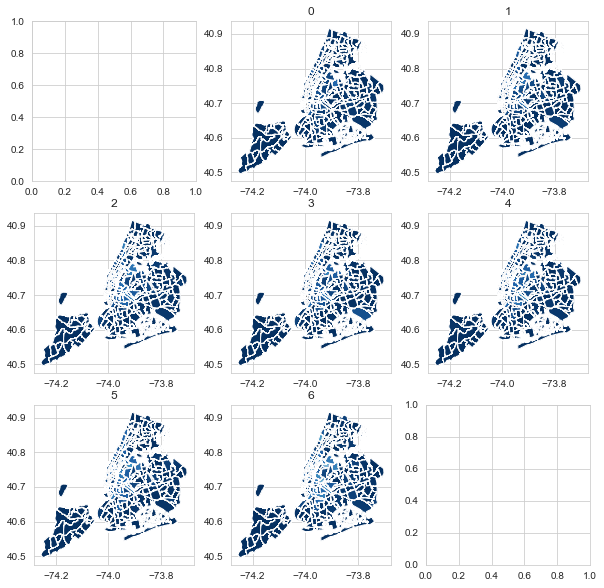

In [91]:
fig,ax = plt.subplots(3,3,figsize=(10,10))
for M in range(1,8):
    Taxi_viz[Taxi_viz['DOW']== M-1].plot(ax=ax[int(M/3),M%3], column='vehicle_count', legend=False, colormap='RdBu_r').set_title(str(M-1))
    

## Task 2: Data preprocessing

### Q1 (3pts), aggregate ridership to date-hour level (over the entire city for all the drop off locations aggregated together), merge with the flight arrival data

In [16]:
TaxiRidership

,DOLocationID,Date,vehicle_count,DOW,Hour,day
0,1,2018-01-01 00:00:00,0.0,0,0,0
1,2,2018-01-01 00:00:00,0.0,0,0,0
2,3,2018-01-01 00:00:00,0.0,0,0,0
3,4,2018-01-01 00:00:00,0.0,0,0,0
4,5,2018-01-01 00:00:00,0.0,0,0,0
...,...,...,...,...,...,...
2251315,259,2018-12-31 23:00:00,2.0,0,23,364
2251316,260,2018-12-31 23:00:00,3.0,0,23,364
2251317,261,2018-12-31 23:00:00,1.0,0,23,364
2251318,262,2018-12-31 23:00:00,8.0,0,23,364


In [17]:
rider_hour = TaxiRidership.groupby(['Date','Hour']).agg({'vehicle_count':'sum'})
rider_hour.head()

,,vehicle_count
Date,Hour,
2018-01-01 00:00:00,0,142.0
2018-01-01 01:00:00,1,23.0
2018-01-01 02:00:00,2,2.0
2018-01-01 03:00:00,3,1.0
2018-01-01 04:00:00,4,13.0


In [18]:
rider_hour = rider_hour.reset_index()
rider_hour.head()

,Date,Hour,vehicle_count
0,2018-01-01 00:00:00,0,142.0
1,2018-01-01 01:00:00,1,23.0
2,2018-01-01 02:00:00,2,2.0
3,2018-01-01 03:00:00,3,1.0
4,2018-01-01 04:00:00,4,13.0


In [19]:
rider_arrival = rider_hour.merge(FlightArrival,on = 'Date')
rider_arrival

,Date,Hour,vehicle_count,arrivals
0,2018-01-01 00:00:00,0,142.0,3
1,2018-01-01 01:00:00,1,23.0,0
2,2018-01-01 02:00:00,2,2.0,1
3,2018-01-01 03:00:00,3,1.0,0
4,2018-01-01 04:00:00,4,13.0,0
...,...,...,...,...
8755,2018-12-31 19:00:00,19,467.0,11
8756,2018-12-31 20:00:00,20,599.0,13
8757,2018-12-31 21:00:00,21,384.0,8
8758,2018-12-31 22:00:00,22,410.0,8


### Q2(3pts), add time-lagged arrivals (1,2,3,4,5,6..12 hours before)

Taxi and FHV ridership volume is impacted by flight arrivals. Intuitively, more flights bring more passengers, and more ridership eventually. However, the hourly ridership volume may not only related to flight arrivals in the same hour, arrivals in 1 hour, 2 hours ago could impact ridership as well, as travelers need some time to pass the costume or wait for luggage. Please add lag add of `arrivals` as additional features, and name new features as `lag1` for `arrivals` 1 hour ago, and `lag2` for 2 hours before and so on. You may use the `shift` function in pandas to add arrivals lag values. For example, df['arrivals'].shift(1) means add 1 hour lag value of arrivals. `iloc` function works as well.

In [20]:
rider_arrival['lag1'] = rider_arrival['arrivals'].shift(1) 
rider_arrival['lag2'] = rider_arrival['arrivals'].shift(2) 
rider_arrival

,Date,Hour,vehicle_count,arrivals,lag1,lag2
0,2018-01-01 00:00:00,0,142.0,3,NaN,NaN
1,2018-01-01 01:00:00,1,23.0,0,3.0,NaN
2,2018-01-01 02:00:00,2,2.0,1,0.0,3.0
3,2018-01-01 03:00:00,3,1.0,0,1.0,0.0
4,2018-01-01 04:00:00,4,13.0,0,0.0,1.0
...,...,...,...,...,...,...
8755,2018-12-31 19:00:00,19,467.0,11,12.0,21.0
8756,2018-12-31 20:00:00,20,599.0,13,11.0,12.0
8757,2018-12-31 21:00:00,21,384.0,8,13.0,11.0
8758,2018-12-31 22:00:00,22,410.0,8,8.0,13.0


## Task 3. Data Exploration

### Q1 (3pts). Print some dataset characteristics: number of records, the total number of FHV and taxi trips, total number of arriving flights


In [21]:
# number of records
len(TaxiRidership)

2251320

In [22]:
# the total number of FHV and taxi trips
TaxiRidership.vehicle_count.sum()

5430922.0

In [23]:
# the total number of arriving flights
FlightArrival.arrivals.sum()

163713

### Q2 (8pts, 4 pts for the figure, 4 pts for the t-test). Plot a probability distribution function of hourly ridership volume on weekdays and weekend, and apply t-test to check is there a significant difference of hourly ridership between each day of week and the rest days, $\alpha=0.05$ Report hypothesis testing result in a $7\times1$ table, index name should be day of week (e.g. Monday), values should be True or False (True for P < 0.05).
Hint: You may use norm.pdf function in scipy.stats to calculate the probability distribution, and standardize at first.

In [24]:
a = TaxiRidership[['Date','DOW']]
rider_arrival = rider_arrival.merge(a,on = 'Date')
rider_arrival = rider_arrival.drop_duplicates()
rider_arrival['vehicle_count_stand']=(rider_arrival['vehicle_count']-rider_arrival['vehicle_count'].mean())/rider_arrival['vehicle_count'].std()

In [25]:
rider_arrival_weekdays = rider_arrival[rider_arrival['DOW']<5]
rider_arrival_weekend = rider_arrival[rider_arrival['DOW']>4]

In [26]:
from scipy.stats import norm
import seaborn as sb
weekdays = norm.pdf(rider_arrival_weekdays.vehicle_count_stand)
weekend = norm.pdf(rider_arrival_weekend.vehicle_count_stand)

### Plot a probability distribution function of hourly ridership volume on weekdays and weekend.

Text(0.5, 1.0, 'Distribution function of hourly ridership volume on weekdays')

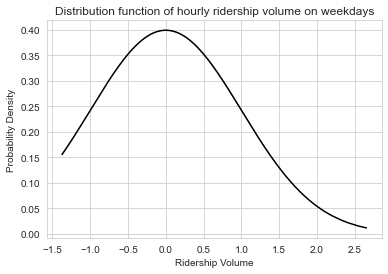

In [27]:
sb.set_style('whitegrid')
sb.lineplot(rider_arrival_weekdays['vehicle_count_stand'] , weekdays , color = 'black')
plt.xlabel('Ridership Volume')
plt.ylabel('Probability Density')
plt.title('Distribution function of hourly ridership volume on weekdays')

Text(0.5, 1.0, 'Distribution function of hourly ridership volume on weekend')

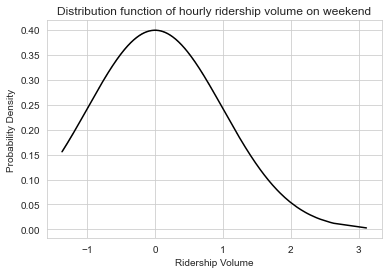

In [28]:
sb.set_style('whitegrid')
sb.lineplot(rider_arrival_weekend['vehicle_count_stand'] ,weekend , color = 'black')
plt.xlabel('Ridership Volume')
plt.ylabel('Probability Density')
plt.title('Distribution function of hourly ridership volume on weekend')

### Apply t-test to check is there a significant difference of hourly ridership between each day of week and the rest days, $\alpha=0.05$ Report hypothesis testing result in a $7\times1$ table, index name should be day of week (e.g. Monday), values should be True or False (True for P < 0.05).


In [29]:
rider_arrival

,Date,Hour,vehicle_count,arrivals,lag1,lag2,DOW,vehicle_count_stand
0,2018-01-01 00:00:00,0,142.0,3,NaN,NaN,0,-1.057751
257,2018-01-01 01:00:00,1,23.0,0,3.0,NaN,0,-1.321100
514,2018-01-01 02:00:00,2,2.0,1,0.0,3.0,0,-1.367574
771,2018-01-01 03:00:00,3,1.0,0,1.0,0.0,0,-1.369787
1028,2018-01-01 04:00:00,4,13.0,0,0.0,1.0,0,-1.343231
...,...,...,...,...,...,...,...,...
2250035,2018-12-31 19:00:00,19,467.0,11,12.0,21.0,0,-0.338521
2250292,2018-12-31 20:00:00,20,599.0,13,11.0,12.0,0,-0.046403
2250549,2018-12-31 21:00:00,21,384.0,8,13.0,11.0,0,-0.522202
2250806,2018-12-31 22:00:00,22,410.0,8,8.0,13.0,0,-0.464663


In [30]:
test = []
for i in [0, 1, 2, 3, 4, 5, 6]:
    rider_arrivala = rider_arrival[rider_arrival['DOW']== i]
    rider_arrivalb = rider_arrival[rider_arrival['DOW']!= i]
    p = stats.ttest_ind(rider_arrivala['vehicle_count_stand'],rider_arrivalb['vehicle_count_stand']).pvalue
    if p < 0.05:
        test.append("True")
    else:
        test.append("False")

test

['True', 'False', 'False', 'True', 'True', 'True', 'False']

In [31]:
table = pd.DataFrame(index = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],columns = ['Values'])

In [32]:
table['Values'] = test
table

,Values
Monday,True
Tuesday,False
Wednesday,False
Thursday,True
Friday,True
Saturday,True
Sunday,False


### Q3(10pts, 3 pts for locate the correct month, 7 pts for the figure.) .  Plot the timeline of the `vehicle_count` and `arrivals` for the month having the highest taxi ridership (the sum of vehicle count in the whole month). As `arrivals` and `vehicle_count` have different scales, standardize each dataset first.

In [33]:
rider_arrival['arrivals_stand']=(rider_arrival['arrivals']-rider_arrival['arrivals'].mean())/rider_arrival['arrivals'].std()

In [34]:
rider_arrival['Month']=pd.DatetimeIndex(rider_arrival.Date).month

In [35]:
rider_arrival.head()

,Date,Hour,vehicle_count,arrivals,lag1,lag2,DOW,vehicle_count_stand,arrivals_stand,Month
0,2018-01-01 00:00:00,0,142.0,3,NaN,NaN,0,-1.057751,-1.176750,1
257,2018-01-01 01:00:00,1,23.0,0,3.0,NaN,0,-1.321100,-1.401769,1
514,2018-01-01 02:00:00,2,2.0,1,0.0,3.0,0,-1.367574,-1.326763,1
771,2018-01-01 03:00:00,3,1.0,0,1.0,0.0,0,-1.369787,-1.401769,1
1028,2018-01-01 04:00:00,4,13.0,0,0.0,1.0,0,-1.343231,-1.401769,1


In [36]:
rider_arrival_month = rider_arrival.groupby(['Month']).agg({'vehicle_count_stand':'sum','arrivals_stand':'sum'})

In [37]:
rider_arrival_month

,vehicle_count_stand,arrivals_stand
Month,,
1,-171.907956,-86.061554
2,-106.412160,-7.186010
3,-92.011434,-58.009217
4,20.726776,28.812675
5,80.367034,29.448070
6,73.575815,64.215624
7,-48.483619,-0.029386
8,16.818062,26.597833
9,22.335639,-1.714869


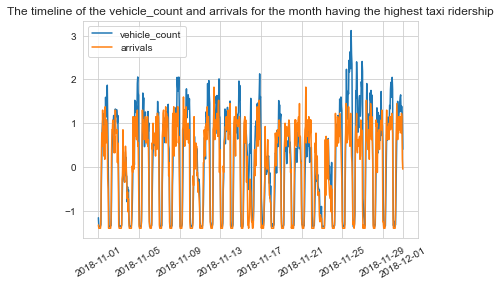

In [38]:
x = rider_arrival[rider_arrival['Month'] == 11].Date
y1 = rider_arrival[rider_arrival['Month'] == 11].vehicle_count_stand
y2 = rider_arrival[rider_arrival['Month'] == 11].arrivals_stand

plt.title('The timeline of the vehicle_count and arrivals for the month having the highest taxi ridership') 
plt.plot(x, y1) 
plt.xticks(rotation = 30)
plt.plot(x, y2)
plt.legend(['vehicle_count', 'arrivals']) 
plt.show()

## Task 4: Build Linear Regression Model of FHV and taxi ridership vs Arrivals data

### Q1 (3pts). split the data into training, validation and test samples (first 90 days for training, next 180 for validation, last 90 for test)


In [39]:
rider_arrival

,Date,Hour,vehicle_count,arrivals,lag1,lag2,DOW,vehicle_count_stand,arrivals_stand,Month
0,2018-01-01 00:00:00,0,142.0,3,NaN,NaN,0,-1.057751,-1.176750,1
257,2018-01-01 01:00:00,1,23.0,0,3.0,NaN,0,-1.321100,-1.401769,1
514,2018-01-01 02:00:00,2,2.0,1,0.0,3.0,0,-1.367574,-1.326763,1
771,2018-01-01 03:00:00,3,1.0,0,1.0,0.0,0,-1.369787,-1.401769,1
1028,2018-01-01 04:00:00,4,13.0,0,0.0,1.0,0,-1.343231,-1.401769,1
...,...,...,...,...,...,...,...,...,...,...
2250035,2018-12-31 19:00:00,19,467.0,11,12.0,21.0,0,-0.338521,-0.576700,12
2250292,2018-12-31 20:00:00,20,599.0,13,11.0,12.0,0,-0.046403,-0.426688,12
2250549,2018-12-31 21:00:00,21,384.0,8,13.0,11.0,0,-0.522202,-0.801719,12
2250806,2018-12-31 22:00:00,22,410.0,8,8.0,13.0,0,-0.464663,-0.801719,12


In [40]:
rider_arrival['day']=((rider_arrival.Date-dt.datetime(2018,1,1))/dt.timedelta(days = 1)).astype(int)

In [41]:
rider_arrival_train = rider_arrival[rider_arrival['day']<81]
rider_arrival_valid = rider_arrival[(rider_arrival['day']>80)&(rider_arrival['day']<261)]
rider_arrival_test = rider_arrival[(rider_arrival['day']>260)&(rider_arrival['day']<351)]

### Q2 (10pts, 6 pts for modeling, 2 pts for the confidence interval, 2 pts for the figure.). 

Build an OLS model with intercept (you may want to use smf.ols) over the training dataset using `arrivals` as a sole predictor for `vehicle_count`. Check p-value for arrival. What does it indicate? Report the 99% confidence interval for arrival's coefficient. Scatter plot for taxi ridership and flight arrival, include the predictive line from linear regression report.

In [42]:
lm = smf.ols(formula='vehicle_count~arrivals', data = rider_arrival_train).fit()
print(lm.summary(alpha=0.01))

                            OLS Regression Results                            
Dep. Variable:          vehicle_count   R-squared:                       0.726
Model:                            OLS   Adj. R-squared:                  0.726
Method:                 Least Squares   F-statistic:                     5155.
Date:                Fri, 17 Dec 2021   Prob (F-statistic):               0.00
Time:                        14:43:50   Log-Likelihood:                -13208.
No. Observations:                1944   AIC:                         2.642e+04
Df Residuals:                    1942   BIC:                         2.643e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.005      0.995]
------------------------------------------------------------------------------
Intercept     76.4277      8.108      9.426      0.0

In [43]:
lm.pvalues

Intercept    1.170711e-20
arrivals     0.000000e+00
dtype: float64

### The p-value for arrival is 0, which indecates the arrivals has a signifcant linear relationship to vehicle_count.

C:\Users\13161\AppData\Local\Temp/ipykernel_6024/1120367781.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rider_arrival_train['predicted']= lm.predict(rider_arrival_train['arrivals'])


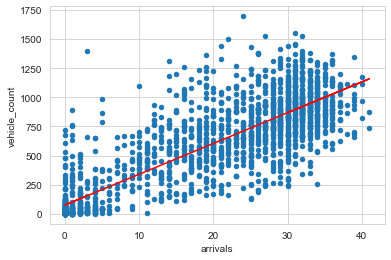

In [44]:
rider_arrival_train['predicted']= lm.predict(rider_arrival_train['arrivals'])
fig, ax = plt.subplots() 
rider_arrival_train.plot(ax=ax,kind='scatter',x='arrivals', y='vehicle_count') #show the data
ax.plot(rider_arrival_train['arrivals'],rider_arrival_train['predicted'],'r-')

### Q3 (8pts): Consider Impact of immediate history of arrivals
by adding time lags - add all 12 lag variables into the regression above

There is always some delay between passengers arrival and departure (e.g. passing customs, picking up luggage, etc). `vehicle_count` might be more related to historical values of flight arrivals (lag) rather than immediate `arrivals`. Engineer a formula with all the following variables and run the regression:
* arrival, lag1, ..., lagN: that happens 1hr, ..., N=12 hr ahead.
Which of the variables have a statistically significant impact according to p-values?


In [45]:
rider_arrival_train

,Date,Hour,vehicle_count,arrivals,lag1,lag2,DOW,vehicle_count_stand,arrivals_stand,Month,day,predicted
0,2018-01-01 00:00:00,0,142.0,3,NaN,NaN,0,-1.057751,-1.176750,1,0,155.548054
257,2018-01-01 01:00:00,1,23.0,0,3.0,NaN,0,-1.321100,-1.401769,1,0,76.427661
514,2018-01-01 02:00:00,2,2.0,1,0.0,3.0,0,-1.367574,-1.326763,1,0,102.801125
771,2018-01-01 03:00:00,3,1.0,0,1.0,0.0,0,-1.369787,-1.401769,1,0,76.427661
1028,2018-01-01 04:00:00,4,13.0,0,0.0,1.0,0,-1.343231,-1.401769,1,0,76.427661
...,...,...,...,...,...,...,...,...,...,...,...,...
498323,2018-03-22 19:00:00,19,1328.0,32,33.0,38.0,3,1.566886,0.998431,3,80,920.378521
498580,2018-03-22 20:00:00,20,1376.0,26,32.0,33.0,3,1.673110,0.548393,3,80,762.137735
498837,2018-03-22 21:00:00,21,1184.0,30,26.0,32.0,3,1.248211,0.848418,3,80,867.631593
499094,2018-03-22 22:00:00,22,1381.0,33,30.0,26.0,3,1.684176,1.073437,3,80,946.751986


In [46]:
M=12
for i in range(1,M+1): 
    rider_arrival_train['lag%d'%i]= rider_arrival_train['arrivals'].shift(i) 
    rider_arrival_valid['lag%d'%i]= rider_arrival_valid['arrivals'].shift(i) 
    rider_arrival_test['lag%d'%i]= rider_arrival_test['arrivals'].shift(i) 
rider_arrival_train.head()

C:\Users\13161\AppData\Local\Temp/ipykernel_6024/2145906148.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rider_arrival_train['lag%d'%i]= rider_arrival_train['arrivals'].shift(i)
C:\Users\13161\AppData\Local\Temp/ipykernel_6024/2145906148.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rider_arrival_valid['lag%d'%i]= rider_arrival_valid['arrivals'].shift(i)
C:\Users\13161\AppData\Local\Temp/ipykernel_6024/2145906148.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

,Date,Hour,vehicle_count,arrivals,lag1,lag2,DOW,vehicle_count_stand,arrivals_stand,Month,...,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,lag11,lag12
0,2018-01-01 00:00:00,0,142.0,3,NaN,NaN,0,-1.057751,-1.176750,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
257,2018-01-01 01:00:00,1,23.0,0,3.0,NaN,0,-1.321100,-1.401769,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
514,2018-01-01 02:00:00,2,2.0,1,0.0,3.0,0,-1.367574,-1.326763,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
771,2018-01-01 03:00:00,3,1.0,0,1.0,0.0,0,-1.369787,-1.401769,1,...,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1028,2018-01-01 04:00:00,4,13.0,0,0.0,1.0,0,-1.343231,-1.401769,1,...,0.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
Pvalue = []
for M in range(1,13):
    formula='vehicle_count~arrivals+'+'+'*(M>1)+'+'.join(['lag%d'%p for p in range(1,M+1)]);
    lm = smf.ols(formula=formula, data = rider_arrival_train).fit()
    Pvalue.append(lm.pvalues)
Pvalue
    


[Intercept     1.310834e-05
 arrivals      4.726517e-55
 lag1         5.181948e-211
 dtype: float64,
 Intercept    1.630665e-01
 arrivals     5.985962e-65
 lag1         7.310529e-66
 lag2         3.611889e-44
 dtype: float64,
 Intercept    9.907003e-01
 arrivals     1.545831e-70
 lag1         9.360191e-62
 lag2         2.100652e-12
 lag3         2.269541e-07
 dtype: float64,
 Intercept    6.111646e-01
 arrivals     1.217814e-70
 lag1         3.174443e-62
 lag2         1.653422e-11
 lag3         4.805914e-03
 lag4         9.428106e-02
 dtype: float64,
 Intercept    3.455652e-02
 arrivals     2.923126e-73
 lag1         6.441278e-66
 lag2         1.847518e-12
 lag3         3.705735e-02
 lag4         2.725151e-02
 lag5         7.577541e-08
 dtype: float64,
 Intercept    1.045523e-03
 arrivals     1.165904e-75
 lag1         6.282880e-66
 lag2         1.535373e-13
 lag3         2.051693e-02
 lag4         6.662733e-03
 lag5         1.296630e-01
 lag6         5.196867e-05
 dtype: float64,
 Int

## Which of the variables have a statistically significant impact according to p-values?
Arrivals, lag1, lag2, and lag3

### Arrivals, lag1, lag2, and lag3 have a statistically significant impact according to its p-values.

### Q4(5pt): Incorporate Temporal Patterns 

adding categorical variables for day of week and hour of the day.

From the visualization in task1Q3, you may see that both - taxi ridership as well as arrivals follow a somewhat periodic temporal pattern. Intuitively, this is true for most traffic flows following daily rhythms including rush hours, and also varying over the course of the week. Usually, we add dummy/categorical variables (Boolean variable: 1 for True and 0 for False) to encapsulate people's traveling patterns during different time periods.

Note that it would not make sense to add hour and dow as regular regressors as we can't anticipate their linear numeric impact. Instead, the expression `C(.)` or `pd.get_dummies` could be used in the regression formulae in order to treat those variables as categorical adding corresponding dummy variables to account for their possible discrete values. 

Perform the regression of `vehicle_count` ridership against `arrivals`, lags, and temporal categorical variables.

In [48]:
rider_arrival_train.columns

Index(['Date', 'Hour', 'vehicle_count', 'arrivals', 'lag1', 'lag2', 'DOW',
       'vehicle_count_stand', 'arrivals_stand', 'Month', 'day', 'predicted',
       'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10',
       'lag11', 'lag12'],
      dtype='object')

In [49]:
rider_arrival_train['Hour']=pd.DatetimeIndex(rider_arrival_train.Date).hour

C:\Users\13161\AppData\Local\Temp/ipykernel_6024/1369913950.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rider_arrival_train['Hour']=pd.DatetimeIndex(rider_arrival_train.Date).hour


In [50]:
rider_arrival_train.loc[:,'DOW'] = rider_arrival_train['DOW'].map({0:'Monday',1:'Tuesday',2:'Wednesday'
                                                             ,3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'})

D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [51]:
hour = pd.get_dummies(rider_arrival_train.Hour)

In [52]:
dow = pd.get_dummies(rider_arrival_train.DOW)

In [53]:
rider_arrival_train_dummy = pd.concat([rider_arrival_train,hour,dow],axis=1,join='inner')

In [54]:
rider_arrival_train_dummy.columns

Index([               'Date',                'Hour',       'vehicle_count',
                  'arrivals',                'lag1',                'lag2',
                       'DOW', 'vehicle_count_stand',      'arrivals_stand',
                     'Month',                 'day',           'predicted',
                      'lag3',                'lag4',                'lag5',
                      'lag6',                'lag7',                'lag8',
                      'lag9',               'lag10',               'lag11',
                     'lag12',                     0,                     1,
                           2,                     3,                     4,
                           5,                     6,                     7,
                           8,                     9,                    10,
                          11,                    12,                    13,
                          14,                    15,                    16,
            

In [55]:
dummy =  rider_arrival_train_dummy.drop(columns=['vehicle_count','Date','Hour','DOW','vehicle_count_stand','arrivals_stand', 'Month', 'day','predicted'])

In [56]:
dummy = dummy.dropna()
rider_arrival_train_dummy = rider_arrival_train_dummy.dropna()
dummy

,arrivals,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,...,21,22,23,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
3084,14,18.0,30.0,15.0,14.0,5.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0
3341,20,14.0,18.0,30.0,15.0,14.0,5.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0
3598,25,20.0,14.0,18.0,30.0,15.0,14.0,5.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0
3855,20,25.0,20.0,14.0,18.0,30.0,15.0,14.0,5.0,0.0,...,0,0,0,0,1,0,0,0,0,0
4112,24,20.0,25.0,20.0,14.0,18.0,30.0,15.0,14.0,5.0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498323,32,33.0,38.0,25.0,28.0,30.0,28.0,33.0,31.0,27.0,...,0,0,0,0,0,0,0,1,0,0
498580,26,32.0,33.0,38.0,25.0,28.0,30.0,28.0,33.0,31.0,...,0,0,0,0,0,0,0,1,0,0
498837,30,26.0,32.0,33.0,38.0,25.0,28.0,30.0,28.0,33.0,...,1,0,0,0,0,0,0,1,0,0
499094,33,30.0,26.0,32.0,33.0,38.0,25.0,28.0,30.0,28.0,...,0,1,0,0,0,0,0,1,0,0


In [57]:
from statsmodels.api import OLS
ols = OLS(rider_arrival_train_dummy.vehicle_count,dummy).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          vehicle_count   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     401.3
Date:                Fri, 17 Dec 2021   Prob (F-statistic):               0.00
Time:                        14:43:51   Log-Likelihood:                -12161.
No. Observations:                1932   AIC:                         2.441e+04
Df Residuals:                    1889   BIC:                         2.465e+04
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
arrivals      10.2668      0.681     15.077      0.000       8.931      11.602
lag1          11.2701      0.761     14.808      0.000       9.777      12.763
lag2           3.3124      0.778      4.260      0.000       1.788       4.837
lag3           1.5218      0.777      1.958      0.050      -0.002       3.046
lag4          -0.4677      0.777     -0.602      0.547      -1.991       1.056
lag5           0.8630      0.776      1.112      0.266      -0.659       2.385
lag6          -0.5631      0.775     -0.727      0.467      -2.082       0.956
lag7          -0.1919      0.777     -0.247      0.805      -1.715       1.331
lag8           0.2650      0.778      0.341      0.733      -1.260       1.790
lag9           1.5393      0.778      1.978      0.048       0.013       3.065
lag10         -0.8548      0.778     -1.099      0.272      -2.381       0.671
lag11          0.8448      0.761      1.111      0.267      -0.647       2.337
lag12         -0.5996      0.679     -0.882      0.378      -1.932       0.733
0            -20.3511     19.022     -1.070      0.285     -57.657      16.955
1           -141.9218     20.159     -7.040      0.000    -181.458    -102.386
2           -104.1357     20.508     -5.078      0.000    -144.357     -63.914
3            -74.5673     20.611     -3.618      0.000    -114.990     -34.145
4            -69.8005     20.518     -3.402      0.001    -110.040     -29.561
5            -60.5062     20.280     -2.984      0.003    -100.279     -20.733
6            -64.9873     20.117     -3.230      0.001    -104.442     -25.533
7            -58.0085     21.702     -2.673      0.008    -100.571     -15.446
8            -70.8441     22.242     -3.185      0.001    -114.465     -27.223
9             -7.1459     22.363     -0.320      0.749     -51.005      36.713
10            12.3341     22.530      0.547      0.584     -31.853      56.521
11           -27.7392     22.314     -1.243      0.214     -71.502      16.024
12           -11.9416     21.441     -0.557      0.578     -53.992      30.109
13           -39.6058     21.588     -1.835      0.067     -81.944       2.732
14            12.2070     21.785      0.560      0.575     -30.518      54.932
15            28.6186     22.016      1.300      0.194     -14.559      71.796
16            45.4662     22.217      2.046      0.041       1.893      89.039
17            77.0160     22.142      3.478      0.001      33.590     120.442
18            78.9064     21.140      3.733      0.000      37.447     120.366
19           105.4452     17.260      6.109      0.000      71.595     139.295
20            85.3180     17.017      5.014      0.000      51.943     118.693
21           226.7754     16.967     13.366      0.000     193.500     260.051
22           191.3794     17.186     11.136      0.000     157.675     225.084
23

### Q5 (8pts, no penalty if students got different results, but no points if students failed to complete 12 models). Perform feature selection for lag variables
As you may see not all the lag variables have a statistically significant impact on the regression. Maybe some of them are not really relevant?
Try different amounts of lag variables m=0,1,...,12 (include m most recent arrival volumes/lags) using a loop for training the above regression over the training sample, report and plot the out-of-sample R2 over the validation sample as the function of m and pick the m which maximizes it. Evaluate the final regression over the test sample.

In [58]:
rider_arrival_valid.head()

,Date,Hour,vehicle_count,arrivals,lag1,lag2,DOW,vehicle_count_stand,arrivals_stand,Month,...,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,lag11,lag12
499608,2018-03-23 00:00:00,0,1116.0,4,NaN,NaN,4,1.097726,-1.101744,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
499865,2018-03-23 01:00:00,1,119.0,1,4.0,NaN,4,-1.108651,-1.326763,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
500122,2018-03-23 02:00:00,2,27.0,0,1.0,4.0,4,-1.312248,-1.401769,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
500379,2018-03-23 03:00:00,3,4.0,0,0.0,1.0,4,-1.363148,-1.401769,3,...,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
500636,2018-03-23 04:00:00,4,9.0,0,0.0,0.0,4,-1.352083,-1.401769,3,...,1.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
rider_arrival_valid['Hour']=pd.DatetimeIndex(rider_arrival_valid.Date).hour
rider_arrival_valid.loc[:,'DOW'] = rider_arrival_valid['DOW'].map({0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'})
hour_valid = pd.get_dummies(rider_arrival_valid.Hour)
dow_valid = pd.get_dummies(rider_arrival_valid.DOW)
rider_arrival_valid_dummy = pd.concat([rider_arrival_valid,hour_valid,dow_valid],axis=1,join='inner')
dummy_valid =  rider_arrival_valid_dummy.drop(columns=['vehicle_count','Date','Hour','DOW','vehicle_count_stand','arrivals_stand', 'Month', 'day'])
dummy_valid = dummy_valid.dropna()
rider_arrival_valid_dummy = rider_arrival_valid_dummy.dropna()

C:\Users\13161\AppData\Local\Temp/ipykernel_6024/800420433.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rider_arrival_valid['Hour']=pd.DatetimeIndex(rider_arrival_valid.Date).hour
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [60]:
dummy_valid.columns 

Index([ 'arrivals',      'lag1',      'lag2',      'lag3',      'lag4',
            'lag5',      'lag6',      'lag7',      'lag8',      'lag9',
           'lag10',     'lag11',     'lag12',           0,           1,
                 2,           3,           4,           5,           6,
                 7,           8,           9,          10,          11,
                12,          13,          14,          15,          16,
                17,          18,          19,          20,          21,
                22,          23,    'Friday',    'Monday',  'Saturday',
          'Sunday',  'Thursday',   'Tuesday', 'Wednesday'],
      dtype='object')

In [61]:
dummy_valid = dummy_valid.drop(columns=['lag%d'%p for p in range(1,13)])
dummy_train = dummy.drop(columns=['lag%d'%p for p in range(1,13)])

In [62]:
dummy_valid.head()

,arrivals,0,1,2,3,4,5,6,7,8,...,21,22,23,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
502692,23,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
502949,32,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
503206,29,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
503463,34,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
503720,30,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [63]:
TrainR2=[0]*12
ValidR2=[0]*12
lm=[0]*12
ypred = []

for M in range(1,13):
    dummy_valid = pd.concat([dummy_valid,rider_arrival_valid_dummy[['lag%d'%n for n in range(M,M+1)]]],axis=1,join='inner')
    dummy_train = pd.concat([dummy_train,rider_arrival_train_dummy[['lag%d'%j for j in range(M,M+1)]]],axis=1,join='inner')
    lm[M-1]= OLS(rider_arrival_train_dummy.vehicle_count,dummy_train).fit()
    ypred =lm[M-1].predict(dummy_valid)
    ValidR2[M-1]=1-((ypred-rider_arrival_valid.vehicle_count)**2).sum()/((rider_arrival_valid.vehicle_count-rider_arrival_valid.vehicle_count.mean())**2).sum()
    TrainR2[M-1]=lm[M-1].rsquared


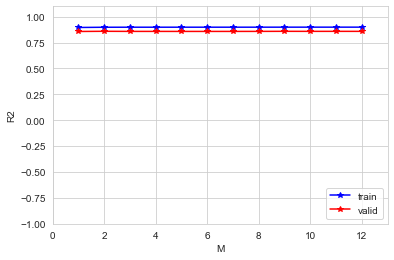

In [64]:
plt.plot(range(1,13),TrainR2[:13],'b-*',label='train')
plt.plot(range(1,13),ValidR2[:13],'r-*',label='valid')
plt.xlabel('M')
plt.ylabel('R2')
plt.ylim(-1,1.1)
plt.xlim(0,13)
plt.legend(loc='lower right')

In [65]:
M=np.argmax(ValidR2)+1; M

2

### Evaluate the final regression over the test sample.

In [66]:
rider_arrival_test['Hour']=pd.DatetimeIndex(rider_arrival_test.Date).hour
rider_arrival_test.loc[:,'DOW'] = rider_arrival_test['DOW'].map({0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'})
hour_test = pd.get_dummies(rider_arrival_test.Hour)
dow_test = pd.get_dummies(rider_arrival_test.DOW)
rider_arrival_test_dummy = pd.concat([rider_arrival_test,hour_test,dow_test],axis=1,join='inner')
dummy_test =  rider_arrival_test_dummy.drop(columns=['vehicle_count','Date','Hour','DOW','vehicle_count_stand','arrivals_stand', 'Month', 'day'])
dummy_test= dummy_test.dropna()
rider_arrival_test_dummy = rider_arrival_test_dummy.dropna()

C:\Users\13161\AppData\Local\Temp/ipykernel_6024/1063030901.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rider_arrival_test['Hour']=pd.DatetimeIndex(rider_arrival_test.Date).hour
D:\Anaconda\envs\geo_env\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [67]:
dummy_test.head()

,arrivals,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,...,21,22,23,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
1612932,29,31.0,32.0,35.0,31.0,22.0,6.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
1613189,32,29.0,31.0,32.0,35.0,31.0,22.0,6.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,1
1613446,37,32.0,29.0,31.0,32.0,35.0,31.0,22.0,6.0,1.0,...,0,0,0,0,0,0,0,0,0,1
1613703,33,37.0,32.0,29.0,31.0,32.0,35.0,31.0,22.0,6.0,...,0,0,0,0,0,0,0,0,0,1
1613960,28,33.0,37.0,32.0,29.0,31.0,32.0,35.0,31.0,22.0,...,0,0,0,0,0,0,0,0,0,1


In [68]:
M = 2
ypred = []
ypred = lm[M-1].predict(dummy_test.drop(columns=['lag%d'%p for p in range(3,13)]))
TestR2 = 1-((ypred-rider_arrival_test.vehicle_count)**2).sum()/((rider_arrival_test.vehicle_count-rider_arrival_test.vehicle_count.mean())**2).sum()
TestR2

-38.68965419042122

### Q6 (9pts, 3 pts for each figure). Visualize temporal patterns and lag impacts through bar plots
For the best regression above, visualize:
- bar plot of hour vs its impact coefficient
- bar plot of day of the week vs its impact coefficient
- bar plot of the lag (0 for immediate arrivals, 1,2,... for lags)

Text(0.5, 1.0, 'bar plot of hour vs its impact coefficient')

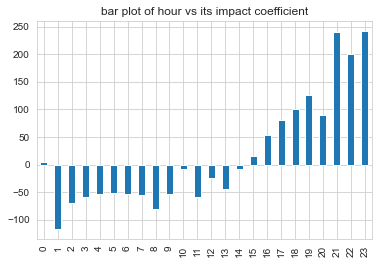

In [69]:
df = pd.DataFrame(lm[M-1].params)
df.loc[0:23].plot.bar(legend=False).set_title('bar plot of hour vs its impact coefficient')

Text(0.5, 1.0, 'bar plot of day of the week vs its impact coefficient')

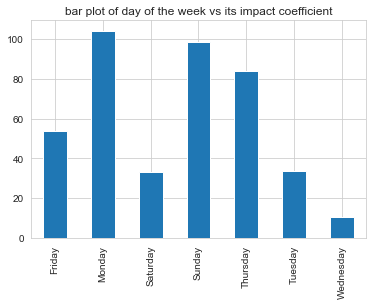

In [70]:
df.loc['Friday':'Wednesday'].plot.bar(legend=False).set_title('bar plot of day of the week vs its impact coefficient')

Text(0.5, 1.0, 'bar plot of the lag')

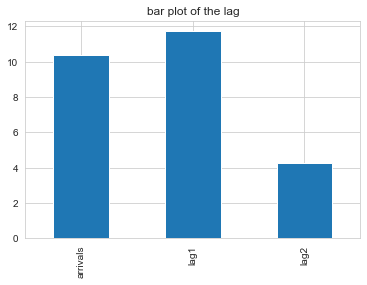

In [71]:
df.loc[['arrivals','lag1','lag2']].plot.bar(legend=False).set_title('bar plot of the lag')

## Task 5. Cluster the days of the year based on the relative timeline of their taxi departures from the airport

### Q1 (3pts). From the entire `dataset`, create a dataframe with days as rows, hours as columns, and taxi ridership as values (feel free to use pd.pivot_table). Normalize each row by the total daily ridership

In [72]:
rider_arrival['Hour']=pd.DatetimeIndex(rider_arrival.Date).hour
rider_arrival.head()

,Date,Hour,vehicle_count,arrivals,lag1,lag2,DOW,vehicle_count_stand,arrivals_stand,Month,day
0,2018-01-01 00:00:00,0,142.0,3,NaN,NaN,0,-1.057751,-1.176750,1,0
257,2018-01-01 01:00:00,1,23.0,0,3.0,NaN,0,-1.321100,-1.401769,1,0
514,2018-01-01 02:00:00,2,2.0,1,0.0,3.0,0,-1.367574,-1.326763,1,0
771,2018-01-01 03:00:00,3,1.0,0,1.0,0.0,0,-1.369787,-1.401769,1,0
1028,2018-01-01 04:00:00,4,13.0,0,0.0,1.0,0,-1.343231,-1.401769,1,0


In [73]:
rider_arrival_pivot = rider_arrival.pivot_table(index=["day"],columns= ['Hour'], values=["vehicle_count"])

In [74]:
rider_arrival_pivot.head()

vehicle_count                                                             \
Hour            0      1     2     3     4     5     6      7      8       9    
day                                                                             
0            142.0   23.0   2.0   1.0  13.0  13.0  15.0   46.0  248.0   443.0   
1            791.0   50.0  28.0   2.0   5.0  16.0  24.0  301.0  550.0  1117.0   
2            674.0  309.0  24.0   3.0   8.0  12.0  44.0  176.0  531.0   777.0   
3            295.0   11.0   2.0   1.0  10.0  15.0  43.0   31.0   32.0    29.0   
4            387.0  164.0  29.0  15.0   7.0  14.0  36.0   92.0   89.0   232.0   

      ...                                                                    \
Hour  ...     14     15     16      17     18     19     20      21      22   
day   ...                                                                     
0     ...  765.0  865.0  776.0  1182.0  804.0  765.0  744.0  1025.0  1196.0   
1     ...  892.0  650.0  820.0   927.0  979.0  940.0  811.0  1048.0  1034.0   
2     ...  700.0  688.0  907.0  1011.0  871.0  713.0  507.0   480.0   566.0   
3     ...   68.0   80.0   40.0    45.0   29.0   28.0   21.0    32.0    37.0   
4     ...  591.0  679.0  723.0   883.0  882.0  950.0  894.0  1055.0   761.0   

              
Hour      23  
day           
0     1079.0  
1      735.0  
2      301.0  
3       72.0  
4      957.0  

[5 rows x 24 columns]

In [75]:
df = rider_arrival_pivot.sum(axis=1)
df

day
0      12553.0
1      14918.0
2      12106.0
3       1188.0
4      11556.0
        ...   
360    14674.0
361    16397.0
362    13922.0
363    15041.0
364    10920.0
Length: 365, dtype: float64

In [76]:
rider_arrival_pivot_norm = rider_arrival_pivot.div(df, axis='rows')
rider_arrival_pivot_norm

vehicle_count                                                    \
Hour            0         1         2         3         4         5    
day                                                                    
0         0.011312  0.001832  0.000159  0.000080  0.001036  0.001036   
1         0.053023  0.003352  0.001877  0.000134  0.000335  0.001073   
2         0.055675  0.025525  0.001982  0.000248  0.000661  0.000991   
3         0.248316  0.009259  0.001684  0.000842  0.008418  0.012626   
4         0.033489  0.014192  0.002510  0.001298  0.000606  0.001211   
..             ...       ...       ...       ...       ...       ...   
360       0.038981  0.008450  0.003544  0.000204  0.000273  0.001159   
361       0.028664  0.040007  0.023785  0.004025  0.000854  0.000915   
362       0.045037  0.009984  0.000287  0.000431  0.000359  0.002155   
363       0.022738  0.006516  0.000066  0.000199  0.000864  0.000665   
364       0.031319  0.001282  0.000458  0.000183  0.000366  0.001099   

                                              ...                      \
Hour        6         7         8         9   ...        14        15   
day                                           ...                       
0     0.001195  0.003664  0.019756  0.035290  ...  0.060942  0.068908   
1     0.001609  0.020177  0.036868  0.074876  ...  0.059794  0.043572   
2     0.003635  0.014538  0.043863  0.064183  ...  0.057823  0.056831   
3     0.036195  0.026094  0.026936  0.024411  ...  0.057239  0.067340   
4     0.003115  0.007961  0.007702  0.020076  ...  0.051142  0.058757   
..         ...       ...       ...       ...  ...       ...       ...   
360   0.004089  0.011858  0.047295  0.058812  ...  0.058539  0.065967   
361   0.003964  0.012197  0.032689  0.046899  ...  0.057998  0.059584   
362   0.004597  0.008763  0.033329  0.043313  ...  0.047694  0.070033   
363   0.004388  0.007579  0.041287  0.050927  ...  0.057044  0.062097   
364   0.001557  0.010440  0.044872  0.059524  ...  0.074267  0.077564   

                                                                            \
Hour        16        17        18        19        20        21        22   
day                                                                          
0     0.061818  0.094161  0.064048  0.060942  0.059269  0.081654  0.095276   
1     0.054967  0.062140  0.065625  0.063011  0.054364  0.070251  0.069312   
2     0.074922  0.083512  0.071948  0.058896  0.041880  0.039650  0.046754   
3     0.033670  0.037879  0.024411  0.023569  0.017677  0.026936  0.031145   
4     0.062565  0.076411  0.076324  0.082208  0.077362  0.091295  0.065853   
..         ...       ...       ...       ...       ...       ...       ...   
360   0.054927  0.067943  0.075508  0.077416  0.062355  0.041093  0.064195   
361   0.059950  0.058913  0.065561  0.061170  0.055315  0.071172  0.074038   
362   0.060623  0.062994  0.073696  0.068525  0.077719  0.075277  0.050998   
363   0.064557  0.066817  0.062695  0.090154  0.056845  0.066751  0.058839   
364   0.054762  0.078022  0.077015  0.042766  0.054853  0.035165  0.037546   

                
Hour        23  
day             
0     0.085956  
1     0.049269  
2     0.024864  
3     0.060606  
4     0.082814  
..         ...  
360   0.045318  
361   0.043971  
362   0.054949  
363   0.061033  
364   0.048626  

[365 rows x 24 columns]

### Q2 (8pts, no penalty if students got different results, but no points if the silhoutte score from different clusters are missing). Try K-means with different numbers of clusters k=2..7, reporting average Silhouette score for each. Which k is the "optimal" from Silhouette's standpoint?

In [77]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

## perform clustring analyses
## try with (3-15 clusters)
for n_clusters in range(2,8): 
    km = KMeans(n_clusters=n_clusters, random_state=324)
    cluster_labels = km.fit_predict(rider_arrival_pivot_norm)
    #report average Silhouette score
    silhouette_avg = silhouette_score(rider_arrival_pivot_norm, cluster_labels)
    print("For n_clusters ={},".format(n_clusters)+" the average silhouette_score is :{}".format(silhouette_avg))



For n_clusters =2, the average silhouette_score is :0.1892982498549995
For n_clusters =3, the average silhouette_score is :0.22324051576230963
For n_clusters =4, the average silhouette_score is :0.23329518409569272
For n_clusters =5, the average silhouette_score is :0.22514662772630323
For n_clusters =6, the average silhouette_score is :0.1760282734467836
For n_clusters =7, the average silhouette_score is :0.17725740332000375


### Q3 (10pts, 3 pts for data processing, 7 for the pivot table). Perform K-means with the optimal k from above. Report the number of occurrences of each day of the week within each of the clusters. How would you interpret the clusters based on that? Visualize the aggregated hourly timeline over all the days within each cluster.
Create a dictionary of the cluster numbers corresponding to each day of the year, apply it adding a column "cluster" to the dataframe, and use pivot table with aggregation function `count` to collect the numbers above. Also, use the pivot table to collect total riders per hour of the day within each cluster for further visualization (after appropriate normalization by the grand total).

In [78]:
km=KMeans(random_state=1,n_clusters=4) 
res=km.fit(rider_arrival_pivot_norm) 
y_t=res.labels_
rider_arrival_pivot_norm['label']=y_t

In [79]:
dict1 = dict(zip(rider_arrival_pivot_norm.index,rider_arrival_pivot_norm['label']))
dict1 

{0: 0,
 1: 1,
 2: 3,
 3: 2,
 4: 0,
 5: 3,
 6: 0,
 7: 1,
 8: 1,
 9: 1,
 10: 0,
 11: 0,
 12: 2,
 13: 0,
 14: 0,
 15: 1,
 16: 0,
 17: 0,
 18: 1,
 19: 3,
 20: 0,
 21: 1,
 22: 1,
 23: 1,
 24: 0,
 25: 1,
 26: 3,
 27: 0,
 28: 1,
 29: 1,
 30: 1,
 31: 0,
 32: 0,
 33: 2,
 34: 0,
 35: 1,
 36: 1,
 37: 0,
 38: 1,
 39: 1,
 40: 3,
 41: 0,
 42: 2,
 43: 1,
 44: 1,
 45: 0,
 46: 0,
 47: 3,
 48: 0,
 49: 0,
 50: 1,
 51: 1,
 52: 0,
 53: 1,
 54: 3,
 55: 0,
 56: 1,
 57: 1,
 58: 1,
 59: 0,
 60: 3,
 61: 3,
 62: 0,
 63: 1,
 64: 1,
 65: 1,
 66: 1,
 67: 1,
 68: 3,
 69: 0,
 70: 1,
 71: 0,
 72: 1,
 73: 1,
 74: 1,
 75: 3,
 76: 0,
 77: 1,
 78: 1,
 79: 2,
 80: 0,
 81: 2,
 82: 3,
 83: 0,
 84: 1,
 85: 1,
 86: 1,
 87: 0,
 88: 1,
 89: 3,
 90: 0,
 91: 0,
 92: 1,
 93: 0,
 94: 1,
 95: 1,
 96: 3,
 97: 0,
 98: 1,
 99: 1,
 100: 1,
 101: 1,
 102: 1,
 103: 3,
 104: 0,
 105: 2,
 106: 1,
 107: 1,
 108: 0,
 109: 2,
 110: 3,
 111: 0,
 112: 1,
 113: 1,
 114: 0,
 115: 2,
 116: 1,
 117: 2,
 118: 0,
 119: 1,
 120: 1,
 121: 1,
 122: 1,
 12

In [80]:
rider_arrival['cluster'] = rider_arrival['day'].apply(lambda x : dict1[x])

In [81]:
rider_arrival[['cluster','day']]

,cluster,day
0,0,0
257,0,0
514,0,0
771,0,0
1028,0,0
...,...,...
2250035,3,364
2250292,3,364
2250549,3,364
2250806,3,364


In [82]:
rider_arrival.head()

,Date,Hour,vehicle_count,arrivals,lag1,lag2,DOW,vehicle_count_stand,arrivals_stand,Month,day,cluster
0,2018-01-01 00:00:00,0,142.0,3,NaN,NaN,0,-1.057751,-1.176750,1,0,0
257,2018-01-01 01:00:00,1,23.0,0,3.0,NaN,0,-1.321100,-1.401769,1,0,0
514,2018-01-01 02:00:00,2,2.0,1,0.0,3.0,0,-1.367574,-1.326763,1,0,0
771,2018-01-01 03:00:00,3,1.0,0,1.0,0.0,0,-1.369787,-1.401769,1,0,0
1028,2018-01-01 04:00:00,4,13.0,0,0.0,1.0,0,-1.343231,-1.401769,1,0,0


In [83]:
pd.pivot_table(rider_arrival, values='Date', index=['cluster'],
                        columns=['DOW'], aggfunc='count')

DOW,0,1,2,3,4,5,6
cluster,,,,,,,
0,144.0,96.0,96.0,360.0,120.0,24.0,1176.0
1,888.0,984.0,984.0,696.0,816.0,48.0,72.0
2,168.0,144.0,120.0,144.0,264.0,216.0,NaN
3,72.0,24.0,48.0,48.0,48.0,960.0,NaN


In [84]:
rider_arrival[(rider_arrival['cluster']==0)&(rider_arrival['DOW']==0)].shape

(144, 12)

### Also, use the pivot table to collect total riders per hour of the day within each cluster for further visualization (after appropriate normalization by the grand total).

In [85]:
rider_arrival['vehicle_count_norm_perhour'] = (rider_arrival['vehicle_count']/rider_arrival['vehicle_count'].sum())/24

In [87]:
df = pd.pivot_table(rider_arrival, values='vehicle_count_norm_perhour', index=['cluster'],
                        columns=['Hour'], aggfunc='sum')
df

Hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.000138,0.000018,0.000004,0.000003,0.000004,0.000006,0.000013,0.000078,0.000202,0.000331,...,0.000562,0.000588,0.000643,0.000681,0.000721,0.000738,0.000718,0.000789,0.000794,0.000758
1,0.000636,0.000074,0.000022,0.000006,0.000009,0.000015,0.000058,0.000544,0.000953,0.001356,...,0.001303,0.001355,0.001446,0.001429,0.001505,0.001526,0.001437,0.001598,0.001434,0.001301
2,0.000364,0.000164,0.000038,0.000006,0.000004,0.000005,0.000017,0.000096,0.000183,0.000253,...,0.000280,0.000278,0.000285,0.000296,0.000303,0.000314,0.000292,0.000323,0.000309,0.000305
3,0.000166,0.000023,0.000008,0.000002,0.000003,0.000004,0.000011,0.000035,0.000113,0.000170,...,0.000233,0.000250,0.000224,0.000253,0.000196,0.000175,0.000140,0.000180,0.000153,0.000187


### Q4(4pts) visualize the hourly timeline for each cluster, and normalize by total riderships in the cluster.

<AxesSubplot:xlabel='Hour'>

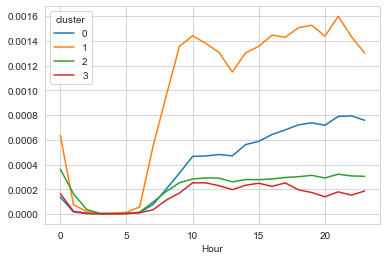

In [88]:
df.T.plot()